In [6]:
# %%
# ==================== BÚSQUEDA RECURSIVA COMPLETA ====================
import os
import pandas as pd
import glob
from collections import defaultdict

DATA_BASE = "/lustre/ific.uv.es/ml/upc150/upc1503/data"

print("="*70)
print("BÚSQUEDA RECURSIVA: AUDIOS Y TRANSCRIPCIONES")
print("="*70)

# %%
# ==================== BUSCAR TODOS LOS AUDIOS RECURSIVAMENTE ====================

def find_all_audio_files(base_dir):
    """Encuentra todos los archivos de audio recursivamente"""
    
    audio_extensions = ['.wav', '.mp3', '.mp4', '.m4a', '.flac', '.ogg']
    
    audio_files = []
    
    for ext in audio_extensions:
        pattern = f"{base_dir}/**/*{ext}"
        files = glob.glob(pattern, recursive=True)
        audio_files.extend(files)
    
    # Crear diccionario por patient_id
    audio_dict = {}
    
    for filepath in audio_files:
        filename = os.path.basename(filepath)
        patient_id = os.path.splitext(filename)[0]
        
        size_mb = os.path.getsize(filepath) / (1024 * 1024)
        _, ext = os.path.splitext(filename)
        
        # Si hay duplicados, quedarse con el de mayor tamaño
        if patient_id in audio_dict:
            if size_mb > audio_dict[patient_id]['size_mb']:
                audio_dict[patient_id] = {
                    'path': filepath,
                    'extension': ext.lower(),
                    'size_mb': round(size_mb, 2),
                    'filename': filename
                }
        else:
            audio_dict[patient_id] = {
                'path': filepath,
                'extension': ext.lower(),
                'size_mb': round(size_mb, 2),
                'filename': filename
            }
    
    return audio_dict

# %%
# ==================== BUSCAR ENGLISH ====================
print("\n" + "="*70)
print("BUSCANDO AUDIOS EN ENGLISH")
print("="*70)

audio_base_en = os.path.join(DATA_BASE, "audios_completos/English")
audio_dict_en = find_all_audio_files(audio_base_en)

print(f"\nAudios únicos encontrados: {len(audio_dict_en)}")

# Agrupar por extensión
by_ext_en = defaultdict(int)
for patient_id, info in audio_dict_en.items():
    by_ext_en[info['extension']] += 1

print(f"\nPor formato:")
for ext, count in sorted(by_ext_en.items(), key=lambda x: -x[1]):
    print(f"  {ext:10s}: {count:4d} archivos")

print(f"\nEjemplos (primeros 10):")
for i, (patient_id, info) in enumerate(list(audio_dict_en.items())[:10], 1):
    rel_path = info['path'].replace(audio_base_en, "")
    print(f"  {i:2d}. {patient_id:20s} {info['extension']:6s} {info['size_mb']:6.2f} MB")
    print(f"      {rel_path}")

# %%
# ==================== BUSCAR SPANISH ====================
print("\n" + "="*70)
print("BUSCANDO AUDIOS EN SPANISH")
print("="*70)

audio_base_es = os.path.join(DATA_BASE, "audios_completos/Spanish")
audio_dict_es = find_all_audio_files(audio_base_es)

print(f"\nAudios únicos encontrados: {len(audio_dict_es)}")

# Agrupar por extensión
by_ext_es = defaultdict(int)
for patient_id, info in audio_dict_es.items():
    by_ext_es[info['extension']] += 1

print(f"\nPor formato:")
for ext, count in sorted(by_ext_es.items(), key=lambda x: -x[1]):
    print(f"  {ext:10s}: {count:4d} archivos")

print(f"\nTodos los archivos Spanish:")
for i, (patient_id, info) in enumerate(audio_dict_es.items(), 1):
    rel_path = info['path'].replace(audio_base_es, "")
    print(f"  {i:2d}. {patient_id:20s} {info['extension']:6s} {info['size_mb']:6.2f} MB")
    print(f"      {rel_path}")

# %%
# ==================== BUSCAR TODOS LOS .CHA ====================
print("\n" + "="*70)
print("BUSCANDO ARCHIVOS .CHA")
print("="*70)

trans_base = os.path.join(DATA_BASE, "transcripciones")
all_cha_files = glob.glob(f"{trans_base}/**/*.cha", recursive=True)

print(f"\nTotal .cha encontrados: {len(all_cha_files)}")

# Crear diccionario por patient_id
cha_dict = {}

for cha_path in all_cha_files:
    filename = os.path.basename(cha_path)
    patient_id = os.path.splitext(filename)[0]
    
    size_kb = os.path.getsize(cha_path) / 1024
    
    # Si hay duplicados, quedarse con el de mayor tamaño
    if patient_id in cha_dict:
        if size_kb > cha_dict[patient_id]['size_kb']:
            cha_dict[patient_id] = {
                'path': cha_path,
                'size_kb': round(size_kb, 2)
            }
    else:
        cha_dict[patient_id] = {
            'path': cha_path,
            'size_kb': round(size_kb, 2)
        }

print(f"Pacientes únicos con .cha: {len(cha_dict)}")

# Filtrar solo los que tienen tamaño > 1KB
cha_dict_ok = {pid: info for pid, info in cha_dict.items() if info['size_kb'] >= 1}
cha_dict_empty = {pid: info for pid, info in cha_dict.items() if info['size_kb'] < 1}

print(f"  OK (>1KB): {len(cha_dict_ok)}")
print(f"  EMPTY (<1KB): {len(cha_dict_empty)}")

# %%
# ==================== HACER MATCH AUDIOS <-> .CHA ====================
print("\n" + "="*70)
print("MATCH: AUDIOS <-> TRANSCRIPCIONES")
print("="*70)

# Combinar todos los audios
all_audio_dict = {}
for pid, info in audio_dict_en.items():
    info['lang'] = 'en'
    all_audio_dict[pid] = info

for pid, info in audio_dict_es.items():
    info['lang'] = 'es'
    all_audio_dict[pid] = info

print(f"\nTotal audios: {len(all_audio_dict)}")
print(f"Total .cha OK: {len(cha_dict_ok)}")

# Hacer match
results = []

for patient_id, audio_info in all_audio_dict.items():
    has_cha = patient_id in cha_dict_ok
    cha_info = cha_dict_ok.get(patient_id, {})
    
    results.append({
        'patient_id': patient_id,
        'lang': audio_info['lang'],
        'audio_path': audio_info['path'],
        'audio_ext': audio_info['extension'],
        'audio_size_mb': audio_info['size_mb'],
        'has_cha': has_cha,
        'cha_path': cha_info.get('path', ''),
        'cha_size_kb': cha_info.get('size_kb', 0),
        'status': 'OK' if has_cha else 'NO_CHA'
    })

df_match = pd.DataFrame(results)

# %%
# ==================== RESUMEN ====================
print("\n" + "="*70)
print("RESUMEN FINAL")
print("="*70)

print(f"\nTotal audios: {len(df_match)}")
print(f"\nPor idioma:")
print(df_match['lang'].value_counts())

print(f"\nPor estado:")
print(df_match['status'].value_counts())

ok_count = len(df_match[df_match['status'] == 'OK'])
no_cha_count = len(df_match[df_match['status'] == 'NO_CHA'])

print(f"\n  Audios con .cha (OK): {ok_count} ({100*ok_count/len(df_match):.1f}%)")
print(f"  Audios sin .cha: {no_cha_count} ({100*no_cha_count/len(df_match):.1f}%)")

# %%
# ==================== ARCHIVOS UTILIZABLES ====================
print("\n" + "="*70)
print("ARCHIVOS UTILIZABLES (con audio + .cha)")
print("="*70)

df_ok = df_match[df_match['status'] == 'OK'].copy()
df_ok = df_ok.sort_values('cha_size_kb', ascending=False)

print(f"\nTotal: {len(df_ok)}")

print(f"\nPor idioma:")
for lang in df_ok['lang'].unique():
    count = len(df_ok[df_ok['lang'] == lang])
    print(f"  {lang.upper()}: {count} pacientes")

print(f"\nTop 20 por tamaño de .cha:")
for i, row in df_ok.head(20).iterrows():
    print(f"  {row['patient_id']:20s} ({row['lang']})  "
          f"audio: {row['audio_size_mb']:6.2f} MB  "
          f"cha: {row['cha_size_kb']:7.2f} KB")

# %%
# ==================== ARCHIVOS SIN .CHA ====================
print("\n" + "="*70)
print("AUDIOS SIN TRANSCRIPCIÓN")
print("="*70)

df_no_cha = df_match[df_match['status'] == 'NO_CHA'].copy()

if len(df_no_cha) > 0:
    print(f"\nTotal: {len(df_no_cha)}")
    
    print(f"\nPor idioma:")
    print(df_no_cha['lang'].value_counts())
    
    print(f"\nEjemplos (primeros 20):")
    for i, row in df_no_cha.head(20).iterrows():
        print(f"  {row['patient_id']:30s} ({row['lang']})  {row['audio_ext']}")
else:
    print("\n¡Todos los audios tienen .cha!")

# %%
# ==================== GUARDAR RESULTADOS ====================
output_file = os.path.join(DATA_BASE, "audio_cha_complete_mapping.csv")
df_match.to_csv(output_file, index=False)

print("\n" + "="*70)
print(f"Mapeo completo guardado en:")
print(f"{output_file}")
print("="*70)

# %%
# ==================== ESTADÍSTICAS FINALES ====================
print("\n" + "="*70)
print("ESTADÍSTICAS FINALES")
print("="*70)

print(f"\nAudios encontrados:")
print(f"  English: {len(audio_dict_en)}")
print(f"  Spanish: {len(audio_dict_es)}")
print(f"  Total: {len(all_audio_dict)}")

print(f"\nTranscripciones (.cha > 1KB):")
print(f"  Total: {len(cha_dict_ok)}")

print(f"\nMatch completo (audio + .cha):")
print(f"  Total: {ok_count}")
print(f"  English: {len(df_ok[df_ok['lang'] == 'en'])}")
print(f"  Spanish: {len(df_ok[df_ok['lang'] == 'es'])}")

print(f"\n¡Listo para procesar {ok_count} pacientes!")

BÚSQUEDA RECURSIVA: AUDIOS Y TRANSCRIPCIONES

BUSCANDO AUDIOS EN ENGLISH

Audios únicos encontrados: 1624

Por formato:
  .wav      : 1491 archivos
  .mp3      :  133 archivos

Ejemplos (primeros 10):
   1. aprocsa1833a         .wav     9.75 MB
      /Protocol/APROCSA/aprocsa1833a.wav
   2. aprocsa1713a         .wav     9.75 MB
      /Protocol/APROCSA/aprocsa1713a.wav
   3. aprocsa1738a         .wav     9.75 MB
      /Protocol/APROCSA/aprocsa1738a.wav
   4. aprocsa1944a         .wav     9.75 MB
      /Protocol/APROCSA/aprocsa1944a.wav
   5. aprocsa1554a         .wav     9.75 MB
      /Protocol/APROCSA/aprocsa1554a.wav
   6. aprocsa1731a         .wav     9.75 MB
      /Protocol/APROCSA/aprocsa1731a.wav
   7. wright207a           .wav     9.25 MB
      /Protocol/Wright/PWA/wright207a.wav
   8. wright206a           .wav     9.25 MB
      /Protocol/Wright/PWA/wright206a.wav
   9. wright203a           .wav     9.25 MB
      /Protocol/Wright/PWA/wright203a.wav
  10. wright205a           .wav

In [7]:
# %%
import os
import glob
import pandas as pd

DATA_BASE = "/lustre/ific.uv.es/ml/upc150/upc1503/data"
AUDIO_BASE = os.path.join(DATA_BASE, "audios_completos")
TRANS_BASE = os.path.join(DATA_BASE, "transcripciones")
CSV_UTTERANCES = os.path.join(DATA_BASE, "df_utterances_complete_FIXED.csv")

print("="*70)
print("ANÁLISIS: AUDIOS DESCARTADOS")
print("="*70)

# %%
# Cargar utterances procesados
df = pd.read_csv(CSV_UTTERANCES)
patients_processed = set(df['patient_id'].unique())

print(f"\nPacientes procesados: {len(patients_processed)}")

# %%
# Construir índice de audios
audio_index = {}
for ext in ['.wav', '.mp3', '.mp4']:
    files = glob.glob(f"{AUDIO_BASE}/**/*{ext}", recursive=True)
    for filepath in files:
        patient_id = os.path.splitext(os.path.basename(filepath))[0]
        size_mb = os.path.getsize(filepath) / (1024 * 1024)
        
        # Determinar idioma
        if '/English/' in filepath:
            lang = 'en'
        elif '/Spanish/' in filepath:
            lang = 'es'
        else:
            lang = 'unknown'
        
        if patient_id in audio_index:
            if size_mb > audio_index[patient_id]['size_mb']:
                audio_index[patient_id] = {'path': filepath, 'size_mb': size_mb, 'lang': lang}
        else:
            audio_index[patient_id] = {'path': filepath, 'size_mb': size_mb, 'lang': lang}

all_audios = set(audio_index.keys())
print(f"Total audios disponibles: {len(all_audios)}")

# %%
# Construir índice de .cha
cha_files = glob.glob(f"{TRANS_BASE}/**/*.cha", recursive=True)
cha_index = {}

for cha_path in cha_files:
    patient_id = os.path.splitext(os.path.basename(cha_path))[0]
    size_kb = os.path.getsize(cha_path) / 1024
    
    if patient_id in cha_index:
        if size_kb > cha_index[patient_id]['size_kb']:
            cha_index[patient_id] = {'path': cha_path, 'size_kb': size_kb}
    else:
        cha_index[patient_id] = {'path': cha_path, 'size_kb': size_kb}

all_cha = set(cha_index.keys())
print(f"Total .cha disponibles: {len(all_cha)}")

# Solo .cha válidos (>1KB)
cha_valid = {pid for pid, info in cha_index.items() if info['size_kb'] >= 1}
print(f".cha válidos (>1KB): {len(cha_valid)}")

# %%
# ANÁLISIS: Audios con .cha pero descartados
audios_with_cha = all_audios & cha_valid
audios_discarded = audios_with_cha - patients_processed

print("\n" + "="*70)
print("AUDIOS CON .CHA VÁLIDO PERO DESCARTADOS")
print("="*70)

print(f"\nAudios con .cha válido: {len(audios_with_cha)}")
print(f"Audios procesados: {len(patients_processed)}")
print(f"Audios descartados: {len(audios_discarded)} ({100*len(audios_discarded)/len(audios_with_cha):.1f}%)")

# %%
# Analizar POR QUÉ fueron descartados
if len(audios_discarded) > 0:
    print(f"\n--- RAZONES DE DESCARTE ---")
    
    discarded_info = []
    
    for patient_id in sorted(audios_discarded):
        audio_info = audio_index[patient_id]
        cha_info = cha_index[patient_id]
        
        # Intentar cargar para ver el problema
        import pylangacq as pla
        
        reason = "unknown"
        try:
            ds = pla.read_chat(cha_info['path'])
            try:
                utterances = list(ds.utterances(participants='PAR'))
                
                if len(utterances) == 0:
                    reason = "no_par_utterances"
                else:
                    # Ver si tienen timestamps
                    with_timestamps = sum(1 for u in utterances if u.time_marks and len(u.time_marks) >= 2)
                    
                    if with_timestamps == 0:
                        reason = "no_timestamps"
                    else:
                        # Ver si timestamps están fuera de rango
                        import librosa
                        try:
                            y, sr = librosa.load(audio_info['path'], sr=16000, mono=True)
                            audio_dur = len(y) / sr
                            
                            valid_utts = 0
                            for u in utterances:
                                if u.time_marks and len(u.time_marks) >= 2:
                                    start_sec = u.time_marks[0] / 1000.0
                                    end_sec = u.time_marks[1] / 1000.0
                                    if start_sec < audio_dur and end_sec <= audio_dur and end_sec > start_sec:
                                        valid_utts += 1
                            
                            if valid_utts == 0:
                                reason = "timestamps_out_of_range"
                            else:
                                reason = "other"
                        except Exception:
                            reason = "audio_load_error"
            except Exception:
                reason = "no_par_participant"
        except Exception:
            reason = "cha_read_error"
        
        discarded_info.append({
            'patient_id': patient_id,
            'lang': audio_info['lang'],
            'audio_size_mb': audio_info['size_mb'],
            'cha_size_kb': cha_info['size_kb'],
            'reason': reason
        })
    
    df_discarded = pd.DataFrame(discarded_info)
    
    print(f"\nPor razón de descarte:")
    print(df_discarded['reason'].value_counts())
    
    print(f"\nPor idioma:")
    print(df_discarded['lang'].value_counts())
    
    # Ejemplos
    print(f"\nEjemplos de descartados (primeros 20):")
    print(df_discarded[['patient_id', 'lang', 'reason', 'cha_size_kb']].head(20).to_string(index=False))
    
    # Guardar lista completa
    output_file = os.path.join(DATA_BASE, "audios_descartados_analisis.csv")
    df_discarded.to_csv(output_file, index=False)
    print(f"\n\nLista completa guardada en: {output_file}")

# %%
# Audios SIN .cha válido
audios_no_cha = all_audios - cha_valid

print("\n" + "="*70)
print("AUDIOS SIN .CHA VÁLIDO")
print("="*70)

print(f"\nTotal: {len(audios_no_cha)}")

if len(audios_no_cha) > 0:
    by_lang = {}
    for pid in audios_no_cha:
        lang = audio_index[pid]['lang']
        by_lang[lang] = by_lang.get(lang, 0) + 1
    
    print(f"\nPor idioma:")
    for lang, count in sorted(by_lang.items()):
        print(f"  {lang.upper()}: {count}")
    
    print(f"\nEjemplos (primeros 20):")
    for i, pid in enumerate(sorted(audios_no_cha)[:20], 1):
        lang = audio_index[pid]['lang']
        has_cha = pid in all_cha
        
        if has_cha:
            cha_size = cha_index[pid]['size_kb']
            print(f"  {i:2d}. {pid:30s} ({lang}) - .cha existe pero <1KB ({cha_size:.2f} KB)")
        else:
            print(f"  {i:2d}. {pid:30s} ({lang}) - sin .cha")

# %%
# RESUMEN FINAL
print("\n" + "="*70)
print("RESUMEN FINAL")
print("="*70)

total_audios = len(all_audios)
processed = len(patients_processed)
with_cha = len(audios_with_cha)
discarded = len(audios_discarded)
no_cha = len(audios_no_cha)

print(f"""
Total audios disponibles: {total_audios}

  Procesados exitosamente:     {processed} ({100*processed/total_audios:.1f}%)
  Con .cha pero descartados:   {discarded} ({100*discarded/total_audios:.1f}%)
  Sin .cha válido:             {no_cha} ({100*no_cha/total_audios:.1f}%)

Tasa de éxito: {100*processed/with_cha:.1f}% de los audios con .cha válido
""")

ANÁLISIS: AUDIOS DESCARTADOS

Pacientes procesados: 738
Total audios disponibles: 1628
Total .cha disponibles: 1549
.cha válidos (>1KB): 1544

AUDIOS CON .CHA VÁLIDO PERO DESCARTADOS

Audios con .cha válido: 1541
Audios procesados: 738
Audios descartados: 803 (52.1%)

--- RAZONES DE DESCARTE ---

Por razón de descarte:
reason
timestamps_out_of_range    789
cha_read_error              12
no_timestamps                2
Name: count, dtype: int64

Por idioma:
lang
en    802
es      1
Name: count, dtype: int64

Ejemplos de descartados (primeros 20):
patient_id lang                  reason  cha_size_kb
     100-1   en timestamps_out_of_range   127.337891
     100-2   en timestamps_out_of_range    96.956055
    1003-1   en timestamps_out_of_range    44.946289
    1003-2   en timestamps_out_of_range    39.904297
    1003-3   en          cha_read_error    41.004883
    1003-4   en timestamps_out_of_range    42.507812
    1003-5   en timestamps_out_of_range    46.040039
    1003-6   en timestamp

In [9]:
# %%
import os
import glob
import pandas as pd
from pathlib import Path, PurePosixPath

DATA_BASE = "/lustre/ific.uv.es/ml/upc150/upc1503/data"
AUDIO_BASE = os.path.join(DATA_BASE, "audios_completos")
TRANS_BASE = os.path.join(DATA_BASE, "transcripciones")

print("="*70)
print("VERIFICACIÓN: EMPAREJAMIENTO AUDIO <-> .CHA")
print("="*70)

# %%
# ==================== UTILIDADES ====================

def get_relative_path(full_path, base_path):
    """Obtiene la ruta relativa (directorio) desde el directorio base."""
    try:
        return os.path.relpath(os.path.dirname(full_path), base_path)
    except Exception:
        return ""

def normalize_rel_path(rel_path: str) -> str:
    """
    Normaliza la ruta relativa para hacerla comparable entre audios y .cha.
    - Quita el segmento 'Protocol' si aparece (cualquier caso).
    - Estandariza separadores y minúsculas.
    - Colapsa dobles barras.
    """
    if not rel_path:
        return ""
    parts = PurePosixPath(rel_path.replace("\\", "/").strip()).parts
    parts = [p for p in parts if p]  # limpia vacíos
    parts = [p for p in parts if p.lower() != "protocol"]
    return "/".join(parts).lower()

def canonical_key(rel_path: str) -> str:
    """
    Clave canónica '<idioma>/<lab>/<grupo>' tras quitar 'Protocol'.
    Útil para comparar ignorando niveles intermedios no relevantes.
    """
    if not rel_path:
        return ""
    parts = [p for p in PurePosixPath(rel_path.replace("\\","/").strip()).parts if p]
    parts = [p for p in parts if p.lower() != "protocol"]
    if not parts:
        return ""
    idioma = parts[0].lower()
    lab    = parts[1].lower() if len(parts) > 1 else ""
    grupo  = parts[-1].lower() if len(parts) > 2 else ""
    return "/".join([p for p in [idioma, lab, grupo] if p])

# %%
# ==================== CONSTRUIR ÍNDICES CON RUTAS RELATIVAS ====================

# Índice de audios con su estructura de carpetas (elige el más grande por paciente)
audio_index = {}
for ext in ['.wav', '.mp3', '.mp4']:
    files = glob.glob(f"{AUDIO_BASE}/**/*{ext}", recursive=True)
    for filepath in files:
        patient_id = os.path.splitext(os.path.basename(filepath))[0]
        rel_path = get_relative_path(filepath, AUDIO_BASE)
        size_mb = os.path.getsize(filepath) / (1024 * 1024)

        # Guarda el mayor por tamaño si hay duplicados del mismo paciente
        if patient_id in audio_index:
            if size_mb > audio_index[patient_id]['size_mb']:
                audio_index[patient_id] = {
                    'path': filepath,
                    'rel_path': rel_path,
                    'size_mb': size_mb,
                    'filename': os.path.basename(filepath)
                }
        else:
            audio_index[patient_id] = {
                'path': filepath,
                'rel_path': rel_path,
                'size_mb': size_mb,
                'filename': os.path.basename(filepath)
            }

print(f"\nAudios encontrados: {len(audio_index)}")

# Índice de .cha con su estructura de carpetas (elige el más grande por paciente)
cha_index = {}
cha_files = glob.glob(f"{TRANS_BASE}/**/*.cha", recursive=True)

for cha_path in cha_files:
    patient_id = os.path.splitext(os.path.basename(cha_path))[0]
    rel_path = get_relative_path(cha_path, TRANS_BASE)
    size_kb = os.path.getsize(cha_path) / 1024

    # Guarda el mayor por tamaño si hay duplicados del mismo paciente
    if patient_id in cha_index:
        if size_kb > cha_index[patient_id]['size_kb']:
            cha_index[patient_id] = {
                'path': cha_path,
                'rel_path': rel_path,
                'size_kb': size_kb,
                'filename': os.path.basename(cha_path)
            }
    else:
        cha_index[patient_id] = {
            'path': cha_path,
            'rel_path': rel_path,
            'size_kb': size_kb,
            'filename': os.path.basename(cha_path)
        }

# Filtrado de .cha “válidos”
cha_valid = {pid: info for pid, info in cha_index.items() if info['size_kb'] >= 1}
print(f".cha encontrados (>1KB): {len(cha_valid)}")

# %%
# ==================== VERIFICAR EMPAREJAMIENTO ====================

patients_with_both = set(audio_index.keys()) & set(cha_valid.keys())
print(f"\nPacientes con audio + .cha: {len(patients_with_both)}")

matches = []

for patient_id in sorted(patients_with_both):
    audio_info = audio_index[patient_id]
    cha_info = cha_valid[patient_id]

    audio_rel = audio_info['rel_path']
    cha_rel = cha_info['rel_path']

    # Normalización para comparación robusta
    audio_rel_norm = normalize_rel_path(audio_rel)
    cha_rel_norm   = normalize_rel_path(cha_rel)

    # Clave canónica opcional (idioma/lab/grupo)
    audio_key = canonical_key(audio_rel)
    cha_key   = canonical_key(cha_rel)

    paths_match_raw   = audio_rel.replace("\\","/").lower() == cha_rel.replace("\\","/").lower()
    paths_match_norm  = audio_rel_norm == cha_rel_norm
    paths_match_canon = audio_key == cha_key

    matches.append({
        'patient_id': patient_id,
        'audio_file': audio_info['filename'],
        'cha_file': cha_info['filename'],
        'audio_rel_path': audio_rel,
        'cha_rel_path': cha_rel,
        'audio_rel_norm': audio_rel_norm,
        'cha_rel_norm': cha_rel_norm,
        'audio_key': audio_key,
        'cha_key': cha_key,
        'paths_match_raw': paths_match_raw,
        'paths_match_norm': paths_match_norm,
        'paths_match_canon': paths_match_canon,
        'audio_size_mb': audio_info['size_mb'],
        'cha_size_kb': cha_info['size_kb'],
    })

df_matches = pd.DataFrame(matches)

# %%
# ==================== ANÁLISIS ====================

print("\n" + "="*70)
print("ANÁLISIS DE EMPAREJAMIENTO")
print("="*70)

total = len(df_matches)
if total == 0:
    print("\nNo hay pacientes con ambos archivos. Revisa rutas base.")
else:
    matching_raw = int(df_matches['paths_match_raw'].sum())
    matching_norm = int(df_matches['paths_match_norm'].sum())
    matching_canon = int(df_matches['paths_match_canon'].sum())

    print(f"\n[CRUDO]     Rutas que coinciden: {matching_raw} ({100*matching_raw/total:.1f}%)")
    print(f"[CRUDO]     Rutas que NO coinciden: {total - matching_raw} ({100*(1 - matching_raw/total):.1f}%)")

    print(f"\n[NORMALIZ]  Rutas que coinciden: {matching_norm} ({100*matching_norm/total:.1f}%)")
    print(f"[NORMALIZ]  Rutas que NO coinciden: {total - matching_norm} ({100*(1 - matching_norm/total):.1f}%)")

    print(f"\n[CANÓNICA]  Clave idioma/lab/grupo coincide: {matching_canon} ({100*matching_canon/total:.1f}%)")
    print(f"[CANÓNICA]  No coinciden: {total - matching_canon} ({100*(1 - matching_canon/total):.1f}%)")

# %%
# ==================== EJEMPLOS ====================

if total > 0:
    # No coincidencias tras normalizar
    df_no_match_norm = df_matches[df_matches['paths_match_norm'] == False]
    if len(df_no_match_norm) > 0:
        print("\n" + "="*70)
        print("EJEMPLOS: RUTAS QUE NO COINCIDEN (TRAS NORMALIZAR)")
        print("="*70)
        print(f"\nTotal: {len(df_no_match_norm)}")
        for _, row in df_no_match_norm.head(30).iterrows():
            print(f"\n{row['patient_id']}:")
            print(f"  Audio (norm): {row['audio_rel_norm']}")
            print(f"  .cha  (norm): {row['cha_rel_norm']}")

    # Sí coincidencias tras normalizar
    df_match_norm = df_matches[df_matches['paths_match_norm'] == True]
    if len(df_match_norm) > 0:
        print("\n" + "="*70)
        print("EJEMPLOS: RUTAS QUE SÍ COINCIDEN (TRAS NORMALIZAR)")
        print("="*70)
        for _, row in df_match_norm.head(10).iterrows():
            print(f"\n{row['patient_id']}:")
            print(f"  Ruta compartida (norm): {row['audio_rel_norm']}")

# %%
# ==================== ANÁLISIS POR ESTRUCTURA DE CARPETAS ====================

print("\n" + "="*70)
print("ESTRUCTURA DE CARPETAS")
print("="*70)

if total > 0:
    # Crudo
    audio_paths = df_matches['audio_rel_path'].unique()
    print(f"\nRutas únicas en audios_completos (CRUDO): {len(audio_paths)}")
    print("Ejemplos (primeras 20):")
    for path in sorted(audio_paths)[:20]:
        count = len(df_matches[df_matches['audio_rel_path'] == path])
        print(f"  {path:50s} ({count} archivos)")

    print("\n---")

    cha_paths = df_matches['cha_rel_path'].unique()
    print(f"\nRutas únicas en transcripciones (CRUDO): {len(cha_paths)}")
    print("Ejemplos (primeras 20):")
    for path in sorted(cha_paths)[:20]:
        count = len(df_matches[df_matches['cha_rel_path'] == path])
        print(f"  {path:50s} ({count} archivos)")

    # Normalizado
    print("\n---")
    audio_norm_paths = df_matches['audio_rel_norm'].unique()
    print(f"\nRutas únicas en audios_completos (NORMALIZADO): {len(audio_norm_paths)}")
    print("Ejemplos (primeras 20):")
    for path in sorted(audio_norm_paths)[:20]:
        count = len(df_matches[df_matches['audio_rel_norm'] == path])
        print(f"  {path:50s} ({count} archivos)")

    print("\n---")
    cha_norm_paths = df_matches['cha_rel_norm'].unique()
    print(f"\nRutas únicas en transcripciones (NORMALIZADO): {len(cha_norm_paths)}")
    print("Ejemplos (primeras 20):")
    for path in sorted(cha_norm_paths)[:20]:
        count = len(df_matches[df_matches['cha_rel_norm'] == path])
        print(f"  {path:50s} ({count} archivos)")

# %%
# ==================== GUARDAR RESULTADOS ====================

output_file = os.path.join(DATA_BASE, "audio_cha_path_matching.csv")
cols = [
    'patient_id','audio_file','cha_file',
    'audio_rel_path','cha_rel_path',
    'audio_rel_norm','cha_rel_norm',
    'audio_key','cha_key',
    'paths_match_raw','paths_match_norm','paths_match_canon',
    'audio_size_mb','cha_size_kb'
]
if total > 0:
    df_matches[cols].to_csv(output_file, index=False)
else:
    # Si no hay filas, guardamos CSV vacío con cabeceras
    pd.DataFrame(columns=cols).to_csv(output_file, index=False)

print("\n" + "="*70)
print(f"Resultados guardados en:")
print(f"{output_file}")
print("="*70)

# %%
# ==================== RECOMENDACIONES ====================

print("\n" + "="*70)
print("RECOMENDACIONES")
print("="*70)

if total == 0:
    print("No se pudo comparar porque no hay pacientes con ambos archivos.")
else:
    not_matching_norm = total - matching_norm
    if not_matching_norm > matching_norm:
        print(f"""
Advertencia: {not_matching_norm} pacientes ({100*not_matching_norm/total:.1f}%) 
siguen con rutas DIFERENTES incluso tras normalizar (ignorando 'Protocol').

Posibles causas:
1) El laboratorio o grupo difiere realmente (p. ej., 'Fridriksson' vs 'Fridriksson-2', 'PWA' vs 'Control').
2) Múltiples sesiones del mismo paciente ('-1', '-2', 'LARC').
3) Reorganización histórica de carpetas.

Recomendación:
- Revisar manualmente estos casos en el CSV.
- Considerar usar SOLO los que coinciden tras normalizar.
- Si procede, usar la comparación por clave canónica (idioma/lab/grupo) como criterio más flexible.
""")
    elif not_matching_norm > 0:
        print(f"""
La mayoría coincide tras normalizar ({matching_norm} de {total}).

Aún hay {not_matching_norm} excepciones que deberías revisar.
Consulta el archivo CSV para detalles (columnas *_norm y *_key).
""")
    else:
        print(f"""
Perfecto: todos los {matching_norm} pacientes coinciden tras normalizar
(ignorando el segmento 'Protocol'). El emparejamiento por patient_id y ruta normalizada es confiable.
""")


VERIFICACIÓN: EMPAREJAMIENTO AUDIO <-> .CHA

Audios encontrados: 1628
.cha encontrados (>1KB): 1544

Pacientes con audio + .cha: 1541

ANÁLISIS DE EMPAREJAMIENTO

[CRUDO]     Rutas que coinciden: 4 (0.3%)
[CRUDO]     Rutas que NO coinciden: 1537 (99.7%)

[NORMALIZ]  Rutas que coinciden: 1511 (98.1%)
[NORMALIZ]  Rutas que NO coinciden: 30 (1.9%)

[CANÓNICA]  Clave idioma/lab/grupo coincide: 1511 (98.1%)
[CANÓNICA]  No coinciden: 30 (1.9%)

EJEMPLOS: RUTAS QUE NO COINCIDEN (TRAS NORMALIZAR)

Total: 30

65-1:
  Audio (norm): english/neural-2/pwa
  .cha  (norm): english/neural/pwa

74-1:
  Audio (norm): english/neural-2/pwa
  .cha  (norm): english/neural/pwa

74-2:
  Audio (norm): english/neural-2/pwa
  .cha  (norm): english/neural/pwa

UMD13:
  Audio (norm): english/umd/control/monolingual
  .cha  (norm): english/umd/control/bilingual

UMD14:
  Audio (norm): english/umd/control/bilingual
  .cha  (norm): english/umd/control/monolingual

UMD19:
  Audio (norm): english/umd/control/bilingual


Librerías cargadas
Patient IDs de audios: 878

Ejemplos (primeros 10):
   1. 005m_150303_1231
   2. 006m_150303_1252
   3. 1012-6
   4. 1030-4
   5. 1034-3
   6. 105-1
   7. 105-2
   8. 1058-1
   9. 1058-2
  10. 1058-3
Patient IDs de .CHA: 1549

Ejemplos (primeros 10):
   1. 100-1
   2. 100-2
   3. 1003-1
   4. 1003-2
   5. 1003-3
   6. 1003-4
   7. 1003-5
   8. 1003-6
   9. 1003-LARC
  10. 1006-1
MATCHING EXACTO (case-sensitive)
Audios procesados:        878
.CHA disponibles:        1549
Emparejados:              798 (90.9% de audios)
Audios sin .CHA:           80 (9.1%)
.CHA sin audio:           751


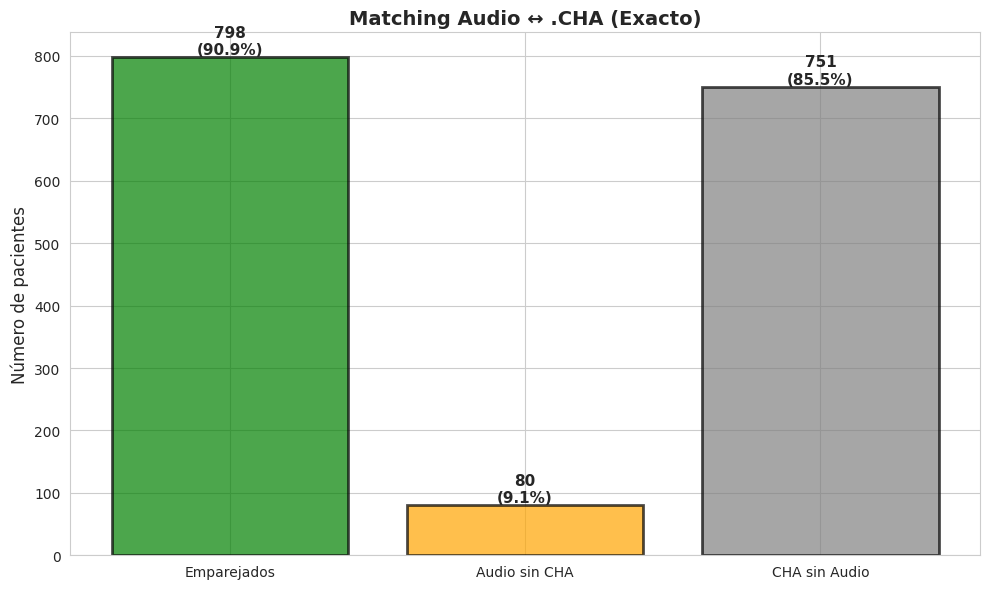

In [1]:
import pandas as pd
import numpy as np
import re
import os
import glob
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("Librerías cargadas")

# Cargar IDs de audios (word alignments)
df_audio = pd.read_csv('word_alignments_ALL.csv')
audio_ids = set(df_audio['patient_id'].unique())

print(f"Patient IDs de audios: {len(audio_ids)}")
print(f"\nEjemplos (primeros 10):")
for i, pid in enumerate(sorted(list(audio_ids))[:10]):
    print(f"  {i+1:2d}. {pid}")

# Buscar archivos .CHA
cha_dir = '/lustre/ific.uv.es/ml/upc150/upc1503/data/transcripciones'
cha_files = glob.glob(os.path.join(cha_dir, '**/*.cha'), recursive=True)
cha_ids = set([os.path.splitext(os.path.basename(f))[0] for f in cha_files])

print(f"Patient IDs de .CHA: {len(cha_ids)}")
print(f"\nEjemplos (primeros 10):")
for i, pid in enumerate(sorted(list(cha_ids))[:10]):
    print(f"  {i+1:2d}. {pid}")

# Matching exacto (case-sensitive)
matched = audio_ids & cha_ids
audio_only = audio_ids - cha_ids
cha_only = cha_ids - audio_ids

print("="*70)
print("MATCHING EXACTO (case-sensitive)")
print("="*70)
print(f"Audios procesados:       {len(audio_ids):4d}")
print(f".CHA disponibles:        {len(cha_ids):4d}")
print(f"Emparejados:             {len(matched):4d} ({100*len(matched)/len(audio_ids):.1f}% de audios)")
print(f"Audios sin .CHA:         {len(audio_only):4d} ({100*len(audio_only)/len(audio_ids):.1f}%)")
print(f".CHA sin audio:          {len(cha_only):4d}")

# Visualizar matching exacto
fig, ax = plt.subplots(figsize=(10, 6))
categories = ['Emparejados', 'Audio sin CHA', 'CHA sin Audio']
values = [len(matched), len(audio_only), len(cha_only)]
colors = ['green', 'orange', 'gray']

bars = ax.bar(categories, values, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax.set_ylabel('Número de pacientes', fontsize=12)
ax.set_title('Matching Audio ↔ .CHA (Exacto)', fontsize=14, fontweight='bold')

# Añadir valores encima de las barras
for bar, val in zip(bars, values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val}\n({100*val/len(audio_ids):.1f}%)',
            ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()

In [2]:
print("="*70)
print("EJEMPLOS DE AUDIOS SIN .CHA (primeros 20)")
print("="*70)

audio_only_sorted = sorted(list(audio_only))
for i, pid in enumerate(audio_only_sorted[:20]):
    print(f"{i+1:2d}. {pid}")

if len(audio_only) > 20:
    print(f"... y {len(audio_only)-20} más")

print(f"\n{'='*70}")
print("EJEMPLOS DE .CHA SIN AUDIO (primeros 20)")
print("="*70)

cha_only_sorted = sorted(list(cha_only))
for i, pid in enumerate(cha_only_sorted[:20]):
    print(f"{i+1:2d}. {pid}")

if len(cha_only) > 20:
    print(f"... y {len(cha_only)-20} más")

EJEMPLOS DE AUDIOS SIN .CHA (primeros 20)
 1. 005m_150303_1231
 2. 006m_150303_1252
 3. 10_2
 4. 11254_cogtests_day1_20140811_part_b
 5. 11254_cogtests_day2_20140822_part_b
 6. 11458_cogtests_day1_20140207_part_b
 7. 11458_cogtests_day1_20140207_part_c
 8. 11458_cogtests_day1_20140207_part_d
 9. 11458_cogtests_day3_20140226_part_a
10. 11458_cogtests_day3_20140226_part_c
11. 11458_cogtests_day3_20140226_part_d
12. 12072_cogtests_day1_20140729_part_a
13. 12072_cogtests_day1_20140729_part_b
14. 12072_cogtests_day2_20140805_part_e
15. 12072_cogtests_day3_20140813_part_b
16. 12072_cogtests_day3_20140813_part_c
17. 12207_cogtests_day1_20141023_part_a
18. 12207_cogtests_day2_20141113_part_a
19. 12288_cogtests_day1_20141216_part_a
20. 12288_cogtests_day1_20141216_part_b
... y 60 más

EJEMPLOS DE .CHA SIN AUDIO (primeros 20)
 1. 100-1
 2. 100-2
 3. 1003-1
 4. 1003-2
 5. 1003-3
 6. 1003-4
 7. 1003-5
 8. 1003-6
 9. 1003-LARC
10. 1006-1
11. 1006-2
12. 1006-3
13. 1006-4
14. 1006-5
15. 1006-6
16. 10

In [4]:
def normalize_id(s, level='aggressive'):
    """Normaliza IDs con diferentes niveles de agresividad"""
    s = str(s)
    
    if level == 'lowercase':
        # Solo lowercase
        return s.lower()
    
    elif level == 'moderate':
        # Lowercase + quitar extensiones
        s = s.lower()
        s = re.sub(r'\.(wav|mp3|cha)$', '', s)
        return s
    
    elif level == 'aggressive':
        # Lowercase + quitar separadores + extensiones
        s = s.lower()
        s = re.sub(r'\.(wav|mp3|cha)$', '', s)
        s = re.sub(r'[_\-\s]+', '', s)
        return s
    
    return s

print("✓ Función de normalización definida")


# Probar diferentes niveles de normalización
results = {}

for level in ['lowercase', 'moderate', 'aggressive']:
    audio_norm = {normalize_id(pid, level): pid for pid in audio_ids}
    cha_norm = {normalize_id(pid, level): pid for pid in cha_ids}
    
    matched_norm = set(audio_norm.keys()) & set(cha_norm.keys())
    
    results[level] = len(matched_norm)
    
    print(f"{'='*70}")
    print(f"MATCHING CON NORMALIZACIÓN: {level.upper()}")
    print("="*70)
    print(f"Emparejados: {len(matched_norm):4d} ({100*len(matched_norm)/len(audio_ids):.1f}% de audios)")
    print(f"Mejora:      {len(matched_norm) - len(matched):+4d} pacientes adicionales")
    
    # Ejemplos de nuevos matches
    if len(matched_norm) > len(matched):
        new_matches = matched_norm - set(matched)
        print(f"\nEjemplos de nuevos matches (primeros 5):")
        for i, norm_id in enumerate(sorted(list(new_matches))[:5]):
            audio_orig = audio_norm[norm_id]
            cha_orig = cha_norm[norm_id]
            print(f"  {i+1}. Audio: {audio_orig:30s} → CHA: {cha_orig}")
            print(f"     Normalizado: {norm_id}")
    print()

✓ Función de normalización definida
MATCHING CON NORMALIZACIÓN: LOWERCASE
Emparejados:  798 (90.9% de audios)
Mejora:        +0 pacientes adicionales

MATCHING CON NORMALIZACIÓN: MODERATE
Emparejados:  798 (90.9% de audios)
Mejora:        +0 pacientes adicionales

MATCHING CON NORMALIZACIÓN: AGGRESSIVE
Emparejados:  798 (90.9% de audios)
Mejora:        +0 pacientes adicionales

